In [24]:
import Ouzo_Sampling_Wtf_Lattice_Volume as create
import OT2_Ouzo_Commands as ot2_commands
import Ouzo_Graph_Tools as ouzo_graphs
from opentrons import simulate, execute, protocol_api
import pandas as pd
import numpy as np

In [75]:
experiment_dict = create.get_experiment_plan(r"C:\Users\Edwin\Desktop\OT2Protocols\ot2protocol\Ouzo_OT2_Sampling\Testing Plans\Testing_Example.csv")

In [76]:
wtf_sample_canidates = create.generate_candidate_lattice_concentrations(experiment_dict) # there is a built in filter for anything summing to over 1, could be somewhat informative
volume_canidates = create.calculate_ouzo_volumes(wtf_sample_canidates, experiment_dict) # this is where you can iterate through a range of stocks and present different sets of possible volumes
filtered_wtf_samples, filtered_volume_samples = create.filter_samples(wtf_sample_canidates, volume_canidates, 30, 1000)
# print('Samples = ', len(filtered_wtf_samples))
# # print((sum(volume_canidates[0][0:4])/sum(volume_canidates[0]))*100)
# for volume in volume_canidates:
#     print(volume)

Samples =  22
[ 32.50000189   6.49999456  67.839518   136.35790587 493.51867089]
[ 46.94444717   6.49999456  67.839518   121.91346058 493.48210267]
[ 61.38889245   6.49999456  67.839518   107.4690153  493.44553446]
[ 75.83333774   6.49999456  67.839518    93.02457002 493.40896624]
[ 90.27778302   6.49999456  67.839518    78.58012473 493.37239803]
[104.7222283    6.49999456  67.839518    64.13567945 493.33582982]
[119.16667359   6.49999456  67.839518    49.69123417 493.2992616 ]
[133.61111887   6.49999456  67.839518    35.24678888 493.26269339]
[148.05556415   6.49999456  67.839518    20.8023436  493.22612518]
[162.50000943   6.49999456  67.839518     6.35789832 493.18955696]
[ 32.50000189  11.19443508  67.839518   131.66346535 493.51272855]
[ 46.94444717  11.19443508  67.839518   117.21902007 493.47616034]
[ 61.38889245  11.19443508  67.839518   102.77457478 493.43959212]
[ 75.83333774  11.19443508  67.839518    88.3301295  493.40302391]
[ 90.27778302  11.19443508  67.839518    73.8856

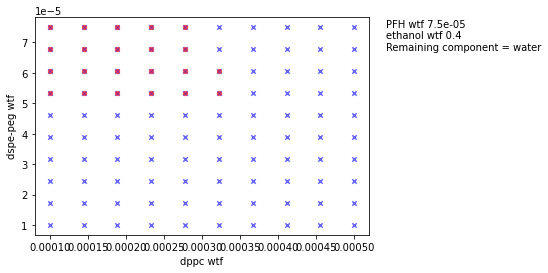

In [77]:
# since autoscaled do not plot sample list with blank
ouzo_graphs.graph_canidates(experiment_dict, wtf_sample_canidates, filtered_wtf_samples) # add log/scinot, exclude blank by -1 on len

In [78]:
# Optional addition of blank samples to sample volumes
average_vol = create.average_volume(filtered_volume_samples)
filtered_wtf_samples_b, filtered_volume_samples_b = create.add_blank(filtered_wtf_samples, filtered_volume_samples,average_vol, experiment_dict['Blank Component Concentrations'])

In [79]:
protocol = simulate.get_protocol_api('2.0')
information = ot2_commands.run(protocol, experiment_dict, filtered_volume_samples_b)

C:\Users\Edwin\.opentrons\deck_calibration.json not found. Loading defaults
C:\Users\Edwin\.opentrons\robot_settings.json not found. Loading defaults


Picking up tip from A1 of Opentrons 96 Tip Rack 1000 µL on 5
Transferring 493.48301687763706 from A1 of Corning 96 Well Plate 360 µL Flat on 1 to A1 of Corning 96 Well Plate 360 µL Flat on 2
Aspirating 493.48301687763706 uL from A1 of Corning 96 Well Plate 360 µL Flat on 1 at 1.0 speed
Dispensing 493.48301687763706 uL into A1 of Corning 96 Well Plate 360 µL Flat on 2 at 1.0 speed
Transferring 493.44644866385374 from A1 of Corning 96 Well Plate 360 µL Flat on 1 to A2 of Corning 96 Well Plate 360 µL Flat on 2
Aspirating 493.44644866385374 uL from A1 of Corning 96 Well Plate 360 µL Flat on 1 at 1.0 speed
Dispensing 493.44644866385374 uL into A2 of Corning 96 Well Plate 360 µL Flat on 2 at 1.0 speed
Transferring 493.4098804500703 from A1 of Corning 96 Well Plate 360 µL Flat on 1 to A3 of Corning 96 Well Plate 360 µL Flat on 2
Aspirating 493.4098804500703 uL from A1 of Corning 96 Well Plate 360 µL Flat on 1 at 1.0 speed
Dispensing 493.4098804500703 uL into A3 of Corning 96 Well Plate 360 µL

In [80]:
create.create_csv(r"C:\Users\Edwin\Desktop\cmonwidg", information, filtered_wtf_samples_b, experiment_dict)
df = pd.read_csv(r"C:\Users\Edwin\Desktop\cmonwidg")

In [81]:
df

,UID,Component 1 wtf,Component 2 wtf,Component 3 wtf,Component 4 wtf,Component 5 wtf,Slot,Labware,Well
0,UID,dppc wtf,dspe-peg wtf,PFH wtf,ethanol wtf,water wtf,Slot,Labware,Well
1,2020-10-13_dppc_dspe-peg_A1,0.0001,5.3333333333333326e-05,7.5e-05,0.4,0.5997716666666666,2,Corning 96 Well Plate 360 µL Flat,A1
2,2020-10-13_dppc_dspe-peg_A2,0.00014444444444444444,5.3333333333333326e-05,7.5e-05,0.4,0.5997272222222222,2,Corning 96 Well Plate 360 µL Flat,A2
3,2020-10-13_dppc_dspe-peg_A3,0.00018888888888888888,5.3333333333333326e-05,7.5e-05,0.4,0.5996827777777778,2,Corning 96 Well Plate 360 µL Flat,A3
4,2020-10-13_dppc_dspe-peg_A4,0.00023333333333333333,5.3333333333333326e-05,7.5e-05,0.4,0.5996383333333333,2,Corning 96 Well Plate 360 µL Flat,A4
5,2020-10-13_dppc_dspe-peg_A5,0.0002777777777777778,5.3333333333333326e-05,7.5e-05,0.4,0.5995938888888889,2,Corning 96 Well Plate 360 µL Flat,A5
6,2020-10-13_dppc_dspe-peg_A6,0.0003222222222222222,5.3333333333333326e-05,7.5e-05,0.4,0.5995494444444445,2,Corning 96 Well Plate 360 µL Flat,A6
7,2020-10-13_dppc_dspe-peg_A7,0.0001,6.0555555555555544e-05,7.5e-05,0.4,0.5997644444444444,2,Corning 96 Well Plate 360 µL Flat,A7
8,2020-10-13_dppc_dspe-peg_A8,0.00014444444444444444,6.0555555555555544e-05,7.5e-05,0.4,0.59972,2,Corning 96 Well Plate 360 µL Flat,A8
9,2020-10-13_dppc_dspe-peg_A9,0.00018888888888888888,6.0555555555555544e-05,7.5e-05,0.4,0.5996755555555555,2,Corning 96 Well Plate 360 µL Flat,A9
